In [1]:
NAME = "Alasdair Breasley"
CIS_USERNAME = "fmcv76"

---

# COMP42415 Text Mining and Language Analytics
## Coursework 2023-24

### Instructions:

- <ins>**DO NOT RENAME THIS JUPYTER NOTEBOOK !!!**</ins>
- Please write the answers for each question in the respective cell. 
- You can add more cells if needed.
- If needed, you can upload additional files, e.g. pre-trained word embeddings, in the coursework's directory
- You can safely remove the `raise NotImplementedError()` line from each code cell.
- You can find information about markdown syntax from [here](https://www.markdownguide.org/basic-syntax/#emphasis).

In [2]:
# Import required packages 
import numpy as np
import pandas as pd
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
nltk.download("averaged_perceptron_tagger")
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,precision_score, recall_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
sns.set() # Use seaborn plotting style
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import gensim
from gensim.models import Word2Vec
import ast
import pickle
import tensorflow as tf


<ipython-input-2-52c8f73f9401>:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package stopwords to
[nltk_data]     /home3/fmcv76/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home3/fmcv76/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home3/fmcv76/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home3/fmcv76/nltk_data...
[nltk_data]   Package averaged_perc

In [3]:
# Controls 
class_balance_sampling = False
subset_data = False
subset_size = 50000 # Total size of the subset used for training and testing 

load_preprocessed_data = True
load_precalculated_w2v_embeddings = True
run_kNN = False
load_NB = True
load_kNN = True
load_CNN = True
load_LSTM = True


## Implementation - Task 1
Prepare the dataset by applying any pre-processing or cleaning steps that you consider as necessary. Then, split the dataset into a training set containing 70% of the samples and a test set containing 30% of the samples. Follow an appropriate strategy for the split. You must use these training/test sets for all the models in this coursework. (**10%**)

In [4]:
if (load_preprocessed_data != True):
    
    # Import food reviews data 
    food_reviews_data = pd.read_csv("food_reviews.csv")
    
    # Check dataframe head 
    print(food_reviews_data.head(5), "\n")
    
    # Check dataframe shape 
    print(food_reviews_data.shape, "\n")
    
    # Check data types 
    print(food_reviews_data.dtypes, "\n")
    
    # Check for missing values 
    print(food_reviews_data.isna().sum())
    
    # Check uniqueness of Score column 
    print(food_reviews_data["Score"].unique(), "\n")
    
    # Check for duplicate rows 
    print(food_reviews_data[food_reviews_data.duplicated()].shape[0], "\n")
    
    # Remove duplicate rows 
    food_reviews_data = food_reviews_data.drop_duplicates()
    
    # Recheck dataframe shape 
    print(food_reviews_data.shape, "\n")
    
    # Concatinate Summary column with Text column to capture all available information 
    food_reviews_data["Text"] = food_reviews_data["Summary"].astype(str) + " " + food_reviews_data["Text"].astype(str)
    
    # TODO: Decide if adding both columns together makes sense 
    
    # Check how many rows contain html tags 
    print(food_reviews_data["Text"].str.contains(r"<.+?>").sum(), "\n")
    
    # Replace html tags with " ", " " as opposed to "" to not join words unintentionally 
    food_reviews_data["Text"] = food_reviews_data["Text"].str.replace(r"<.+?>", " ", regex = True)
    
    # Recheck how many rows contain html tags 
    print(food_reviews_data["Text"].str.contains(r"<.+?>").sum(), "\n")
    
    # Transform Text column to all lowercase 
    food_reviews_data["Text"] = food_reviews_data["Text"].str.lower()
    
    # Remove all "-", ".", "'" and replace with "" e.g. lower-case to lowercase, U.K to UK, don't to dont 
    food_reviews_data["Text"] = food_reviews_data["Text"].str.replace(r"[-.']", "", regex = True)
    
    # Check how many rows include happy or sad text emojis 
    print(food_reviews_data["Text"].str.contains(r"[:][)]|[:][(]|[)][:]|[(][:]").sum(), "\n")
    
    # Replace happy emojis with " happy " 
    food_reviews_data["Text"] = food_reviews_data["Text"].str.replace(r"[:][)]|[(][:]", " happy ", regex = True)
    
    # Replace sad emojis with " sad " 
    food_reviews_data["Text"] = food_reviews_data["Text"].str.replace(r"[:][(]|[)][:]", " sad ", regex = True)
    
    # Recheck how many rows include happy or sad text emojis 
    print(food_reviews_data["Text"].str.contains(r"[:][)]|[:][(]|[)][:]|[(][:]").sum(), "\n")
    
    # Check how many rows include punctuation 
    print(food_reviews_data["Text"].str.contains(r"[^\w\s]").sum(), "\n")
    
    # TODO: Decide if "'" should be removed at this point or if some of the later steps can handle don't etc. 
    
    # Remove punctuation 
    food_reviews_data["Text"] = food_reviews_data["Text"].str.replace(r"[^\w\s]", " ", regex = True)
    
    # Recheck how many rows include punctuation 
    print(food_reviews_data["Text"].str.contains(r"[^\w\s]").sum(), "\n")
    
    # Check for class imbalance 
    print(food_reviews_data["Score"].value_counts(), "\n")
    
    # There is class imbalance present 
    
    # Check dataframe head 
    print(food_reviews_data.head(5), "\n")


In [5]:
# FUNCTIONS FOR FILE TO LOAD IN FINAL FUNCTION 

# TODO: Transfer functions over 

def clean_text(text):
    """Function to clean text input to ensure input strings are processed in the same way as for 
    model train and test data."""
    
    # Note: code here is different to preprocessing in the main script as the latter is for processing whole 
    # pandas series and the former is individual stings. The results are identical. 
    
    # Check text input is a string 
    if (not isinstance(text, str)):
        
        raise Exception("text input is not a string.")
    
    # Transform text to all lowercase 
    text = text.lower()
    
    # Remove all "-", ".", "'" and replace with "" e.g. lower-case to lowercase, U.K to UK, don't to dont 
    text = re.sub(r"[-.']", "", text)
    
    # Replace html tags with " " 
    text = re.sub(r"<.+?>", " ", text)
    
    # Replace happy emojis with " happy " 
    text = re.sub(r"[:][)]|[(][:]", " happy ", text)
    
    # Replace sad emojis with " sad " 
    text = re.sub(r"[:][(]|[)][:]", " sad ", text)
    
    # Remove punctuation 
    text = re.sub(r"[^\w\s]", " ", text)
    
    return text
    
def penn_to_wordnet(penn_pos_tag):
    """Function to convert Penn Treeback POS tags to WordNet."""
    
    tag_dictionary = {"NN":"n", "JJ":"a","VB":"v", "RB":"r"}
    
    try:
        
        # If the first two characters of the Penn Treebank POS tag are in the tag_dictionary 
        return tag_dictionary[penn_pos_tag[:2]]
    
    except:
        
        return "n" # Default to Noun if no mapping available   
    
    
def remove_stopwords_and_lemmatise(text):
    """Function to tokenise a string, remove stop words, lemmatise, and return a list of words."""
    
    # Check text input is a string 
    if (not isinstance(text, str)):
        
        raise Exception("text input is not a string.")
    
    # Tokenise text into words 
    words = word_tokenize(text)
    
    # Get list of English stop words 
    stopwords_english = stopwords.words("english")
    
    # Remove stop words 
    words_filtered = [word for word in words if word not in stopwords_english]
    
    # TODO: Update to use full conversion table as opposed to simplified version 
    
    # Apply POS tagging 
    words_pos_tagged = pos_tag(words_filtered)
    
    # Create a WordNetLemmatizer object 
    wnl = WordNetLemmatizer()
    
    # Define empty lemmas list 
    lemmas = []
    
    # Loop through words in sentence and lemmatise 
    for word, tag in words_pos_tagged:
    
        lemmas.append(wnl.lemmatize(word, pos = penn_to_wordnet(tag)))
    
    # Concatinate remaining words back into a string 
    return lemmas
    
    
def text_to_single_vector(text, w2v_word_embeddings):
    """Function to trasform text (a review) in the form of a list of word embeddings into a single 
    vector representation which is the average vector representation of the embedded words in the review."""
    
    # Check text input is a list  
    if (not isinstance(text, list)):
        
        raise Exception("text input is not a list.")
    
    vector = sum(w2v_word_embeddings.wv[word] for word in text if word in w2v_word_embeddings.wv) / len(text)
    
    return vector
    
    

In [6]:
if (load_preprocessed_data != True):
    
    if (subset_data != True):
        
        subset_size = len(food_reviews_data)
        
        
    if (class_balance_sampling != True):
        
        # Temporarily reduce dataframe size for developement 
        food_reviews_data = food_reviews_data[0:subset_size]
        
        
    # Check for class imbalance 
    print(food_reviews_data["Score"].value_counts())
    
    # There is class imbalance present 
    

In [7]:
if (load_preprocessed_data != True):
    
    def penn_to_wordnet(penn_pos_tag):
        """Function to convert Penn Treeback POS tags to WordNet."""
        
        tag_dictionary = {"NN":"n", "JJ":"a","VB":"v", "RB":"r"}
        
        try:
            
            # If the first two characters of the Penn Treebank POS tag are in the tag_dictionary 
            return tag_dictionary[penn_pos_tag[:2]]
        
        except:
            
            return "n" # Default to Noun if no mapping available 
        
    
    # Get list of English stop words 
    stopwords_english = stopwords.words("english")
    
    def remove_stopwords_and_lemmatise(text):
        """Function to tokenise a string, remove stop words, lemmatise, and return a list of words."""
        
        # Check text input is a string 
        if (not isinstance(text, str)):
            
            raise Exception("text input is not a string.")
        
        # Tokenise text into words 
        words = word_tokenize(text)
        
        # Remove stop words 
        words_filtered = [word for word in words if word not in stopwords_english]
        
        # TODO: Update to use full conversion table as opposed to simplified version 
        
        # Apply POS tagging 
        words_pos_tagged = pos_tag(words_filtered)
        
        # Create a WordNetLemmatizer object 
        wnl = WordNetLemmatizer()
        
        # Define empty lemmas list 
        lemmas = []
        
        # Loop through words in sentence and lemmatise 
        for word, tag in words_pos_tagged:
        
            lemmas.append(wnl.lemmatize(word, pos = penn_to_wordnet(tag)))
        
        # Concatinate remaining words back into a string 
        return lemmas
    
    
    #if (class_balance_sampling != True):
        
        # Remove stop words from Text column 
        #food_reviews_data_tokenised = food_reviews_data["Text"].apply(remove_stopwords_and_lemmatise)
    

In [8]:
if (load_preprocessed_data != True):
    
    if (class_balance_sampling != True):
        
        # Split data into training (70%) and test (30%) splits 
        train_data, test_data, train_labels, test_labels = train_test_split(food_reviews_data["Text"], food_reviews_data["Score"], 
                                                                            test_size = 0.3, random_state = 123, 
                                                                            stratify = food_reviews_data["Score"])
        
        # TODO: Decide if it should be stratified random sampling or random sampling 
        
        # TODO: Remove the seed as it should not be used for real evaluation of model performance 
        
        # Remove stop words from train data and lemmatise 
        train_data_tokenised = train_data.apply(remove_stopwords_and_lemmatise)
        
        # Join lists of lemmas to string (need both ways) 
        train_data = [" ".join(lemmas) for lemmas in train_data_tokenised]
        
        # Remove stop words from test data and lemmatise 
        test_data_tokenised = test_data.apply(remove_stopwords_and_lemmatise)
        
        # Join lists of lemmas to string (need both ways) 
        test_data = [" ".join(lemmas) for lemmas in test_data_tokenised]
    

In [9]:
if (load_preprocessed_data != True):
    
    # Save tokenised train data to csv 
    train_data_tokenised_csv = pd.Series(train_data_tokenised)
    train_data_tokenised_csv.to_csv("train_data_tokenised.csv")
    
    # Save train data to csv 
    train_data_csv = pd.DataFrame({"Text" : train_data, 
                                   "Score" : train_labels})
    train_data_csv.to_csv("train_data.csv")
    
    # Save tokenised test data to csv 
    test_data_tokenised_csv = pd.Series(test_data_tokenised)
    test_data_tokenised_csv.to_csv("test_data_tokenised.csv")
    
    # Save test data to csv 
    test_data_csv = pd.DataFrame({"Text" : test_data, 
                                  "Score" : test_labels})
    test_data_csv.to_csv("test_data.csv")
    

In [10]:
if (load_preprocessed_data == True):
    
    # Load preprocessed tokenised train data 
    train_data_tokenised = pd.read_csv("train_data_tokenised.csv", index_col = 0)["Text"].tolist()
    train_data_tokenised = [ast.literal_eval(text) for text in train_data_tokenised]
    
    # Load preprocessed train data 
    train_data = pd.read_csv("train_data.csv", index_col = 0)["Text"].tolist()
    
    # Load train labels 
    train_labels = pd.read_csv("train_data.csv", index_col = 0)["Score"].tolist()
    
    # Load preprocessed tokenised test data 
    test_data_tokenised = pd.read_csv("test_data_tokenised.csv", index_col = 0)["Text"].tolist()
    test_data_tokenised = [ast.literal_eval(text) for text in test_data_tokenised]
    
    # Load preprocessed test data 
    test_data = pd.read_csv("test_data.csv", index_col = 0)["Text"].tolist()
    
    # Load train labels 
    test_labels = pd.read_csv("test_data.csv", index_col = 0)["Score"].tolist()
    
    # TODO: Check if any list items are empty strings 
    

In [11]:
if (load_preprocessed_data != True):
    
    if (class_balance_sampling == True):
        
        # Define the number of samples for the test set 
        n_samples_test = round(subset_size * 0.3)
        
        total_samples = food_reviews_data.shape[0]
        
        test_size_proportion = n_samples_test / total_samples
        
        train_data_preclassbalanced, test_data = train_test_split(food_reviews_data, test_size = test_size_proportion, 
                                                                  random_state = 123, stratify = food_reviews_data["Score"])
    
        test_data = test_data.reset_index(drop = True)
        
        test_data["Text"] = test_data["Text"].apply(remove_stopwords_and_lemmatise)
        
        # Check for class imbalance 
        print(test_data["Score"].value_counts(), "\n")
        
        # Check for class imbalance 
        print(train_data_preclassbalanced["Score"].value_counts(), "\n")
        
        n_samples_per_class = round(n_samples_test * (7 / 3) / 5)
        
        # TODO: Return error if not enough of any class present 
        
        classes = train_data_preclassbalanced["Score"].unique()
        
        sampled_class_dataframes = []
        
        for class_ in classes:
            
            class_dataframe = train_data_preclassbalanced[train_data_preclassbalanced["Score"] == class_]
            
            sampled_class_dataframe = class_dataframe.sample(n = n_samples_per_class, random_state = 123)
            
            sampled_class_dataframes.append(sampled_class_dataframe)
        
        
        train_data = pd.concat(sampled_class_dataframes).reset_index(drop = True)
        
        train_data["Text"] = train_data["Text"].apply(remove_stopwords_and_lemmatise)
        
        # Check for class imbalance 
        print(train_data["Score"].value_counts(), "\n")
        
        test_labels = test_data["Score"]
        
        test_data = test_data["Text"]
        
        train_labels = train_data["Score"]
        
        train_data = train_data["Text"]
    

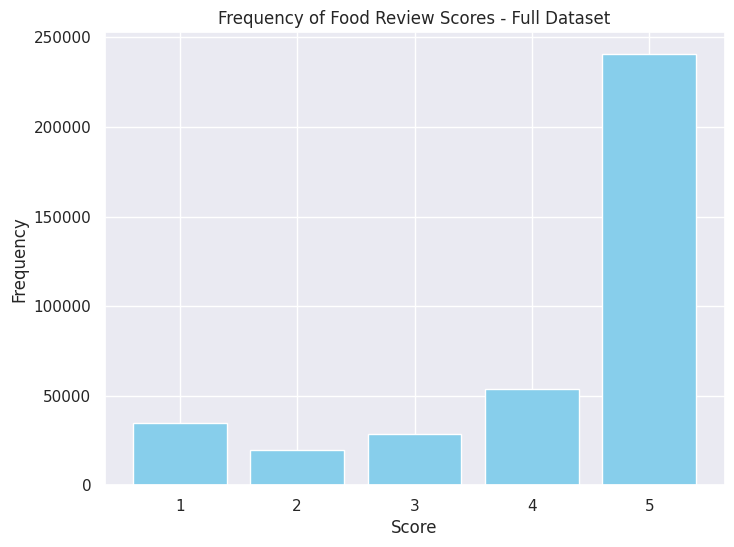

In [12]:
# Visualise the frequency of Score values for the entire dataset 
all_scores = pd.Series(train_labels + test_labels)
all_frequencies = all_scores.value_counts()
all_frequencies = all_frequencies.reset_index()
all_frequencies.columns = ["Score", "Frequency"]

plt.figure(figsize = (8, 6), dpi = 100)
plt.bar(all_frequencies["Score"], all_frequencies["Frequency"], color = "skyblue")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Frequency of Food Review Scores - Full Dataset")
plt.show()


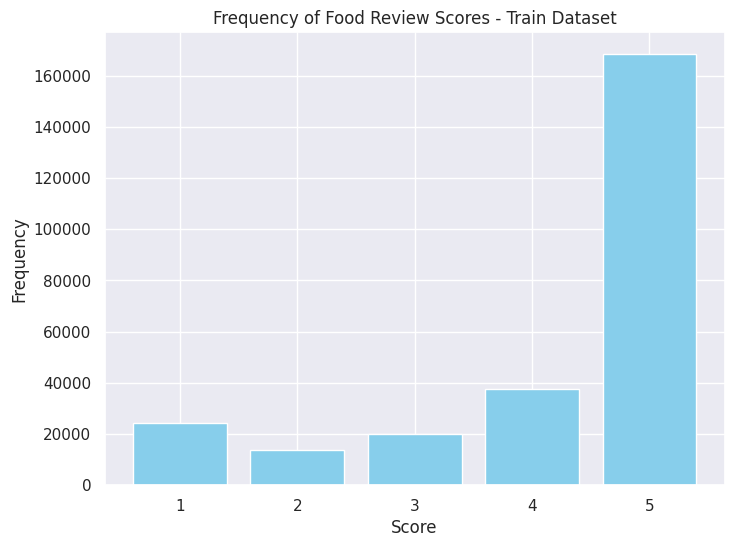

In [13]:
# Visualise the frequency of Score values for the train dataset 
train_scores = pd.Series(train_labels)
train_frequencies = train_scores.value_counts()
train_frequencies = train_frequencies.reset_index()
train_frequencies.columns = ["Score", "Frequency"]

plt.figure(figsize = (8, 6), dpi = 100)
plt.bar(train_frequencies["Score"], train_frequencies["Frequency"], color = "skyblue")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Frequency of Food Review Scores - Train Dataset")
plt.show()


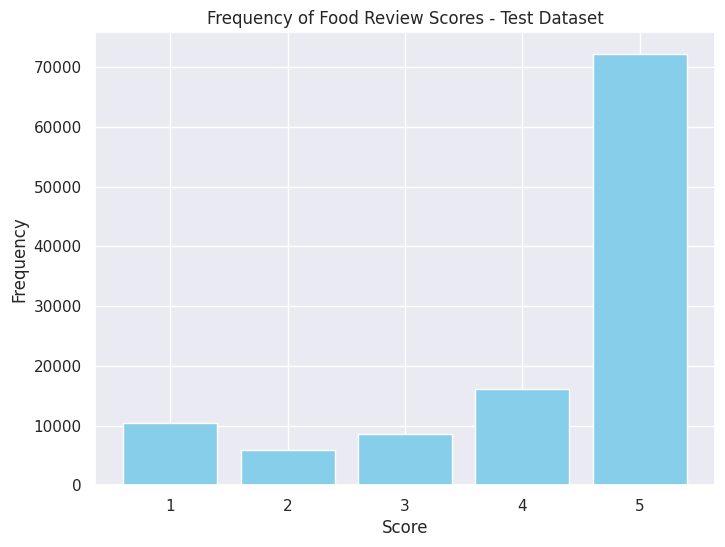

In [14]:
# Visualise the frequency of Score values for the test dataset 
test_scores = pd.Series(test_labels)
test_frequencies = test_scores.value_counts()
test_frequencies = test_frequencies.reset_index()
test_frequencies.columns = ["Score", "Frequency"]

plt.figure(figsize = (8, 6), dpi = 100)
plt.bar(test_frequencies["Score"], test_frequencies["Frequency"], color = "skyblue")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Frequency of Food Review Scores - Test Dataset")
plt.show()


## Implementation - Task 2
Implement a Naïve Bayes model for predicting the rating of a food review. Train your model on the training set and test it on the test set. Use an appropriate text representation. (**5%**)

In [15]:
if (load_NB != True):
    
    # Naive Bayes model - input is converted to TF-IDF vectors and then Multinomial Naive Bayes is used 
    nb_model = make_pipeline(TfidfVectorizer(), MultinomialNB())
    
    # Tune model for best value of alpha (lapace smoothing parameter) using 5-fold cross-validation 
    # More coarse grid searching was undertaken initially to narrow down to the below range 
    grid = {"multinomialnb__alpha" : [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]}
    
    grid_search = GridSearchCV(nb_model, grid, cv = 5, scoring = "accuracy")
    
    # TODO: Decide if F1-Score better 
    
    # TODO: Decide if adding fit_prior to the grid search makes sense 
    
    grid_search.fit(train_data, train_labels)
    
    best_alpha = grid_search.best_params_["multinomialnb__alpha"]
    
    print(best_alpha)
    
    nb_model.set_params(multinomialnb__alpha = best_alpha)
    
    # Train model 
    nb_model.fit(train_data, train_labels)
    
    # Save model 
    nb_model_filename = "nb_model.pkl"
    
    with open(nb_model_filename, "wb") as file:
        
        pickle.dump(nb_model, file)
        

In [16]:
if (load_NB == True):
    
    with open("nb_model.pkl", "rb") as file:
        
        nb_model = pickle.load(file)
    

In [17]:
# Test model 
nb_predictions = nb_model.predict(test_data)


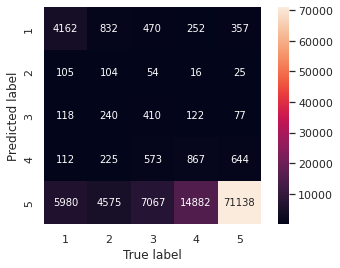

Accuracy:	0.676158
F1-score:	0.304875
Precision:	0.499185
Recall:		0.300185

Classification performance:
              precision    recall  f1-score   support

           1       0.69      0.40      0.50     10477
           2       0.34      0.02      0.03      5976
           3       0.42      0.05      0.09      8574
           4       0.36      0.05      0.09     16139
           5       0.69      0.98      0.81     72241

    accuracy                           0.68    113407
   macro avg       0.50      0.30      0.30    113407
weighted avg       0.60      0.68      0.58    113407



In [18]:
# Plot the confusion matrix
score_catagory_labels = [1, 2, 3, 4, 5]

matrix = confusion_matrix(test_labels, nb_predictions)
sns.heatmap(matrix.T, square = True, annot = True, fmt = "d", 
           xticklabels = score_catagory_labels, yticklabels = score_catagory_labels)
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_labels, nb_predictions))
print("F1-score:\t%f" % f1_score(test_labels, nb_predictions, average = "macro"))
print("Precision:\t%f" % precision_score(test_labels, nb_predictions, average = "macro"))
print("Recall:\t\t%f" % recall_score(test_labels, nb_predictions, average = "macro"))
print("\nClassification performance:\n%s" % classification_report(test_labels, nb_predictions))


## Implementation - Task 3
Implement a k-Nearest Neighbours model for predicting the rating of a food review. Train your model on the training set and test it on the test set. Use an appropriate text representation. You must select the best k by examining the performance of the model for $k \in \{1,3,5,7\}$, using an appropriate cross-validation approach. Create a plot for k vs. classification performance to justify your choice. (**10%**)

In [19]:
if (run_kNN):
    
    if (load_precalculated_w2v_embeddings != True):
        
        # Train word2vec word embedding model using train data to create denser vectors  
        w2v_word_embeddings = gensim.models.Word2Vec(train_data_tokenised, vector_size = 300, window = 5, 
                                                     min_count = 1, sg = 0, seed = 123)
        
        # Save word2vec word embeddings 
        w2v_word_embeddings.save("w2v_word_embeddings.model")
        
# TODO: Explain why vector_size and window chosen 


In [20]:
if (load_precalculated_w2v_embeddings == True):
    
    # Load word2vec word embeddings 
    w2v_word_embeddings = Word2Vec.load("w2v_word_embeddings.model")
        

In [21]:
if (run_kNN):
    
    def text_to_single_vector(text, w2v_word_embeddings):
        """Function to trasform text (a review) in the form of a list of word embeddings into a single 
        vector representation which is the average vector representation of the embedded words in the review."""
        
        # Check text input is a list  
        if (not isinstance(text, list)):
            
            raise Exception("text input is not a list.")
        
        vector = sum(w2v_word_embeddings.wv[word] for word in text if word in w2v_word_embeddings.wv) / len(text)
        
        return vector


In [22]:
# Vectorise train data into dense vector representations 
train_data_w2v_vectorized = [text_to_single_vector(text, w2v_word_embeddings) for text in train_data_tokenised]

# Vectorise test data into dense vector representations 
test_data_w2v_vectorized = [text_to_single_vector(text, w2v_word_embeddings) for text in test_data_tokenised]


In [23]:
if (run_kNN):
    
    # Values of k to test 
    k_values = [1, 3, 5, 7]
    
    mean_accuracies = []
    
    for k in k_values:
        
        knn_model = KNeighborsClassifier(n_neighbors = k)
        
        scores = cross_val_score(knn_model, train_data_w2v_vectorized, train_labels, cv = 5, scoring = "accuracy")
        
        # TODO: Explain why Accuracy vs F1-Score - If doing class balanced sampling then doesn't matter, 
        # if not then F1-Score makes most sense because of class imbalance 
        
        # TODO: Decide on if to tune for weights and metric parameters too 
        
        mean_accuracy = scores.mean()
        
        mean_accuracies.append(mean_accuracy)
        
        
    plt.figure(figsize = (10, 6))
    plt.plot(k_values, mean_accuracies, marker = "o", linestyle = "-", color = "b")
    plt.title("kNN Model Performance by Number of Neighbors")
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("Mean Accuracy")
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()


In [24]:
if (run_kNN):
    
    if (load_kNN != True):
        
        # k Nearest Neighbour model - input is converted to TF-IDF vectors and then kNN is used 
        # The k value which produced the hgihest accuracy from cross-validation on the train/validation set is used 
        knn_model = KNeighborsClassifier(n_neighbors = k_values[mean_accuracies.index(max(mean_accuracies))])
        
        # Train model 
        knn_model.fit(train_data_w2v_vectorized, train_labels)
        
        # Save model 
        knn_model_filename = "knn_model.pkl"
        
        with open(knn_model_filename, "wb") as file:
            
            pickle.dump(knn_model, file)
        
    if (load_kNN == True):
        
        with open("knn_model.pkl", "rb") as file:
            
            knn_model = pickle.load(file)
            
    # Test model 
    knn_predictions = knn_model.predict(test_data_w2v_vectorized)


In [25]:
if (run_kNN):
    
    # Plot the confusion matrix
    score_catagory_labels = [1, 2, 3, 4, 5]
    
    matrix = confusion_matrix(test_labels, knn_predictions)
    sns.heatmap(matrix.T, square = True, annot = True, fmt = "d", 
                xticklabels = score_catagory_labels, yticklabels = score_catagory_labels)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.show()
    
    # Compute and print classification performance metrics
    print("Accuracy:\t%f" % accuracy_score(test_labels, knn_predictions))
    print("F1-score:\t%f" % f1_score(test_labels, knn_predictions, average = "macro"))
    print("Precision:\t%f" % precision_score(test_labels, knn_predictions, average = "macro"))
    print("Recall:\t\t%f" % recall_score(test_labels, knn_predictions, average = "macro"))
    print("\nClassification performance:\n%s" % classification_report(test_labels, knn_predictions))


## Implementation - Task 4
Implement a Convolutional Neural Network (CNN) model for predicting the rating of a food review. The model must have at least two convolutional layers. Train your model on the training set and test it on the test set. Use an appropriate text representation. (**13%**)

In [26]:
#train_data_w2v_vectorized = train_data_w2v_vectorized[0:50000]

#train_labels = train_labels[0:50000]

train_labels_minus1 = [score - 1 for score in train_labels]

#test_data_w2v_vectorized = test_data_w2v_vectorized[0:10000]

#test_labels = test_labels[0:10000]

test_labels_minus1 = [score - 1 for score in test_labels]

In [27]:
embedding_size = 300

ffnn_model = tf.keras.models.Sequential()
ffnn_model.add(tf.keras.Input(shape = (embedding_size, )))
ffnn_model.add(tf.keras.layers.Dense(128, activation = "relu"))
ffnn_model.add(tf.keras.layers.Dense(5, activation = "softmax"))

#ffnn_model.summary()

In [28]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.001)

ffnn_model.compile(optimizer = optimiser, loss = "sparse_categorical_crossentropy", metrics = "accuracy")

epochs = 10

x_train = np.array(train_data_w2v_vectorized)
y_train = np.array(train_labels_minus1)
x_test = np.array(test_data_w2v_vectorized)
y_test = np.array(test_labels_minus1)

history = ffnn_model.fit(x = x_train, y = y_train, validation_data = (x_test, y_test), epochs = epochs, verbose = 0)


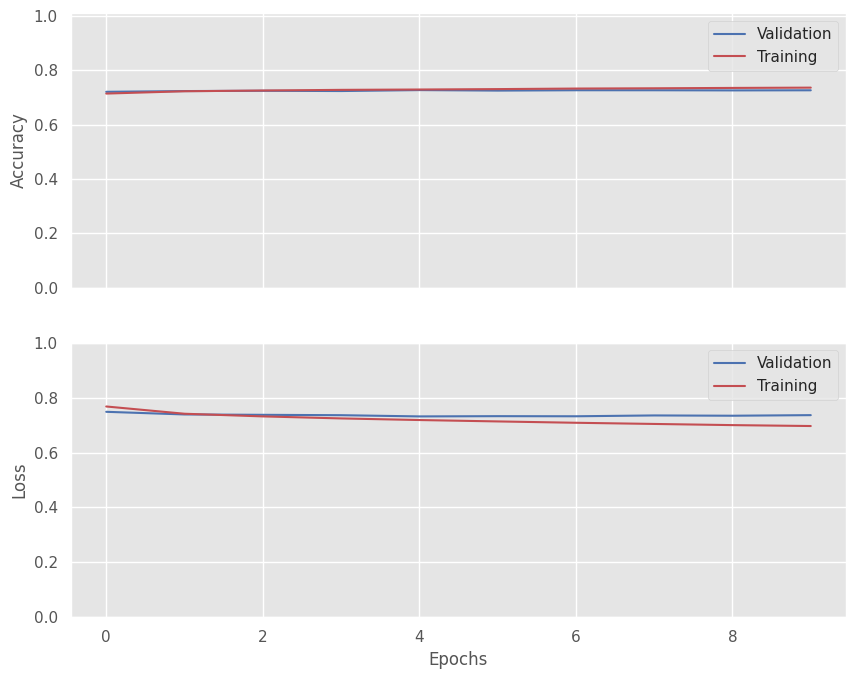

In [29]:
plt.style.use("ggplot")
fig, (ax1, ax2) = plt.subplots(2, figsize = (10, 8), dpi = 100, sharex = True)
ax1.set_ylim([0, 1.01])
ax1.plot(history.history["val_accuracy"],"b")
ax1.set_ylabel("Accuracy")
ax1.plot(history.history["accuracy"],"r")
ax1.legend(["Validation", "Training"])
ax2.set_ylim([0, 1])
ax2.plot(history.history["val_loss"], "b")
ax2.plot(history.history["loss"], "r")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epochs")
ax2.legend(["Validation","Training"])

In [30]:
# Test model 
ffnn_predictions = ffnn_model.predict(np.array(test_data_w2v_vectorized))

3544/3544 [==============================] - 5s 1ms/step


In [31]:
ffnn_predictions_labels = np.argmax(ffnn_predictions, axis = 1)

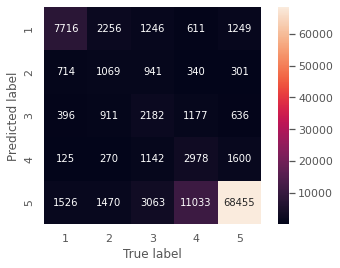

Accuracy:	0.726587
F1-score:	0.466770
Precision:	0.521285
Recall:		0.460391

Classification performance:
              precision    recall  f1-score   support

           0       0.59      0.74      0.66     10477
           1       0.32      0.18      0.23      5976
           2       0.41      0.25      0.31      8574
           3       0.49      0.18      0.27     16139
           4       0.80      0.95      0.87     72241

    accuracy                           0.73    113407
   macro avg       0.52      0.46      0.47    113407
weighted avg       0.68      0.73      0.69    113407



In [32]:
# Plot the confusion matrix
score_catagory_labels = [1, 2, 3, 4, 5]

matrix = confusion_matrix(test_labels_minus1, ffnn_predictions_labels)
sns.heatmap(matrix.T, square = True, annot = True, fmt = "d", 
           xticklabels = score_catagory_labels, yticklabels = score_catagory_labels)
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_labels_minus1, ffnn_predictions_labels))
print("F1-score:\t%f" % f1_score(test_labels_minus1, ffnn_predictions_labels, average = "macro"))
print("Precision:\t%f" % precision_score(test_labels_minus1, ffnn_predictions_labels, average = "macro"))
print("Recall:\t\t%f" % recall_score(test_labels_minus1, ffnn_predictions_labels, average = "macro"))
print("\nClassification performance:\n%s" % classification_report(test_labels_minus1, ffnn_predictions_labels))

In [33]:
# TODO: Try not removing stop words and see if that increases accuracy 

In [34]:
# Calculate the number of words in each review after preprocessing etc. 
all_data_tokenised = train_data_tokenised + test_data_tokenised

n_words = [len(text) for text in all_data_tokenised]

In [35]:
# Summary statistics for the number of words per review 
pd.Series(n_words).describe()

count    378022.000000
mean         43.180701
std          40.890849
min           2.000000
25%          20.000000
50%          31.000000
75%          52.000000
max        2017.000000
dtype: float64

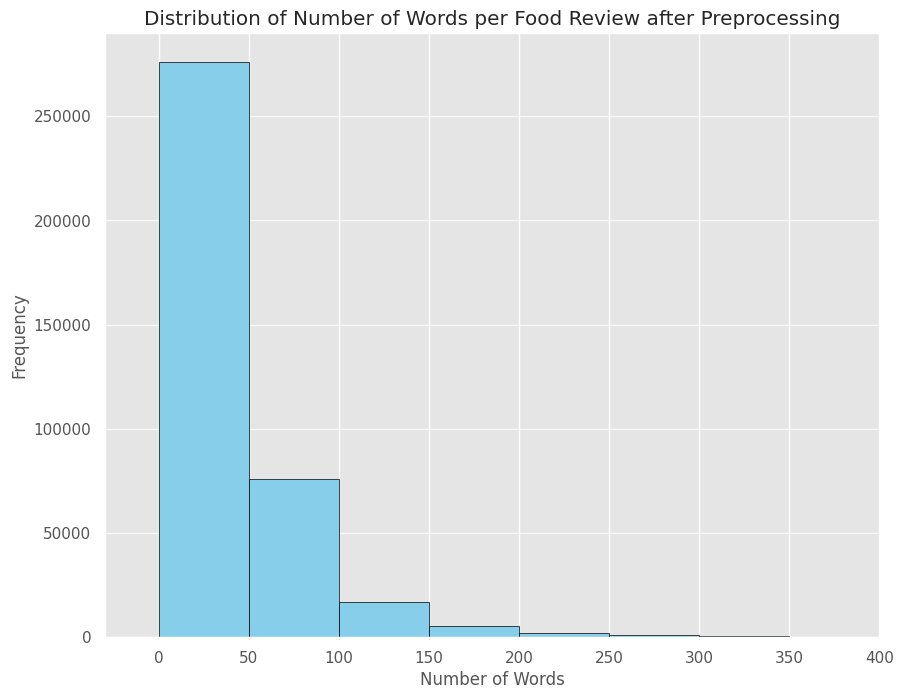

Note: y axis limited to show only visible columns. Number of words values go as high as 2017.


In [36]:
plt.figure(figsize = (10, 8), dpi = 100)
plt.hist(n_words, bins = range(0, 2100, 50), color = "skyblue", edgecolor = "black")
plt.title("Distribution of Number of Words per Food Review after Preprocessing")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(axis = "y", alpha = 0.75)
plt.xlim([-30, 400])
plt.show()

max_words = round(pd.Series(n_words).describe()["max"])
print(f"Note: y axis limited to show only visible columns. Number of words values go as high as {max_words}.")

## Implementation - Task 5
Implement a Recurrent Neural Network (RNN) or a Long Short-Term Memory (LSTM) model for predicting the rating of a food review. The model must have at least two RNN/LSTM layers. Train your model on the training set and test it on the test set. Use an appropriate text representation. (**12%**)

## Implementation - Task 6
Compute the confusion matrix, accuracy, F1-score, precision and recall for each model. (10%)

## Implementation - Task 7
Store the **four** trained models in files and implement a function `predict_food_review(text, model)` that given a <ins>text string</ins> (“`text`”) and model <ins>filename</ins> (“`model`”), it will load the pre-trained model, and predict the food review rating of the input text. The function should be able to work without requiring to rerun all or part of your code. (**10%**)

In [37]:
# Function works under the assumption that all the required packages above are loaded 

# TODO: Decide if loading packages within the function so it is completely self contained makes sense 

def predict_food_review(text, model):
    """Function to predict the Score (1 to 5) of a food review using pretrained Naive Bayes, k Nearest Neighbours, 
    Convolutional Neural Network, and Long Short-Term Memory models. Provide input text as a string. 
    Choose models from: "nb_model.pkl", "kNN_model.pkl", "cnn_model.pkl", and "lstm_model.pkl"."""
    
    # TODO: Make variable and file naming consistent 
    
    # Check text input is a string 
    if (not isinstance(text, str)):
        
        raise Exception("text input is not a string.")
        
    # Check model filename input is a string 
    if (not isinstance(model, str)):
        
        raise Exception("model filename input is not a string.")
        
    # Check a valid model filename input is provided 
    valid_model_filenames = ["nb_model.pkl", "kNN_model.pkl", "cnn_model.pkl", "lstm_model.pkl"]
    
    if (not model in valid_model_filenames):
        
        raise Exception("model filename input is not a valid option. \nValid options include: \n'nb_model.pkl', 'kNN_model.pkl', 'cnn_model.pkl', and 'lstm_model.pkl'")
    
    # TODO: Source script containing all created functions 
    
    #from TMLA_Assignment_Functions import clean_text, penn_to_wordnet, remove_stopwords_and_lemmatise 
    
    # TODO: If I'm going to load fucntions in from .py file I need to import packages used within the functions 
    # within the functions in the .py file 
    
    # Clean text in the same way as for initial train and test 
    text = clean_text(text)
    
    # POS tag, remove stop words, and lemmatise in the same way as for initial train and test and return a list of lemmas 
    text = remove_stopwords_and_lemmatise(text)
    
    # Naive Bayes 
    if (model == "nb_model.pkl"):
        
        # Join lists of lemmas to string 
        text = " ".join(text)
        
        # Make text an element of a list - required for predict() 
        text = [text]
        
        # Load Naive Bayes model 
        with open("nb_model.pkl", "rb") as file:
            
            nb_model = pickle.load(file)
            
        # Returns np array 
        predicted_score = nb_model.predict(text)
        
        # Extract element from array and convert to string 
        predicted_score = str(predicted_score.item())
        
        return predicted_score
    
    # k Nearest Neighbour 
    if (model == "kNN_model.pkl"):
        
        #from TMLA_Assignment_Functions import text_to_single_vector
        
        # Load word2vec word embeddings 
        w2v_word_embeddings = Word2Vec.load("w2v_word_embeddings.model")
        
        # Vectorise text into a dense vector representation 
        text = [text_to_single_vector(text, w2v_word_embeddings)]
        
        # Load k Nearest Neighbours 
        with open("knn_model.pkl", "rb") as file:
            
            knn_model = pickle.load(file)
            
        # Returns np array 
        predicted_score = knn_model.predict(text)
        
        # Extract element from array and convert to string 
        predicted_score = str(predicted_score.item())
        
        return predicted_score
        
        
 

## Report - Task 1
Critical discussion about the dataset (suitability, problems, class balance, etc.). (**6%**)

- Dataset has 3 features and 540,031 observations - this is large enough for meaningful sentiment analysis to be undertaken and large enough that the computational complexity of data processing and modelling methods needed to be considered to prevent prohibitively long run times. 
- No missing values in Score column. 
- No missing values in Text column. 
- 27 missing values in Summary column - this doesn't really matter though because we primarily care about Text and Score. 
- No unexpected values in the Score column - only 1, 2, 3, 4, 5. 
- Dataset has 162,009 duplicate rows. 
- The Text column contains raw text which is not tokenised or preprocessed: HTML tags and punctuation which need removed, emojis such as smiley faces which need removed or transformed, and raw text containing capital letters which needs to be lowercased. 
- Class imbalance with majority of observations with a Score of 5. 

## Report - Task 2
Description and justification of the data preparation step(s) used. (**6%**)

- Deduplication to prevent the data biasing the models due to erroneous repeated rows. 
- HTML tag removal, emoji transformation into words, lowercasing, -, ., and ' removal with no space, and punctuation removal to remove noise and non-useful information from the Text. This helps computationally because it will lead to denser vector representations of the text due to not repeating capitalised vs not versions of words etc. This was undertaken on both Summary and Text columns. 
- The Summary and Text columns were concatinated as from manual checking it was determined that the Summary column also contained useful information regarding the sentiment of reviews. 
- The text was then tokenised. 
- Stop words were removed to remove noise / potentially uniformative words and to create denser vectors making the processing and modelling less computationally intesive, given the relatively large dataset. A standard set of English stopwords was used from the NLTK package. There is potentially some drop in modelling accuracy in exchange for the reduced computational complexity as words such as "not", "wasn't" etc. were removed which could negate positive words and change the sentiment of reviews. 
- Penn Treeback POS tagging was then applied with tags subsequently converted to simpler WordNet POS tags. This simplification could result in a reduction in accuracy with only Nouns, Verbs, Adverbs, and Adjectives as classes for tagging and if no mapping was available words were defaulted to Nouns. 
- Words were then lemmatised to create denser vectors making the processing and modelling less computationally intesive, given the relatively large dataset. 
- Further processing of the tokenised / lemmatised text was then undertaken for the different representations used by the different models, with this processing detailed below. 

## Report - Task 3
Description and commentary on the machine learning architectures used, including a description and justification of the text representation method(s) used. (**7%**)

YOUR ANSWER HERE

## Report - Task 4
Detailed performance evaluation of the trained machine learning models in terms of the computed performance metrics. (**5%**)

YOUR ANSWER HERE

## Report - Task 5
Critical discussion on the achieved results, including potential limitations and usage instructions/suggestions. (**6%**)

YOUR ANSWER HERE